# Batch Normalization
One way to make deep networks easier to train is to use more sophisticated optimization procedures such as SGD+momentum, RMSProp, or Adam. Another strategy is to change the architecture of the network to make it easier to train. 
One idea along these lines is batch normalization which was proposed by [1] in 2015.

The idea is relatively straightforward. Machine learning methods tend to work better when their input data consists of uncorrelated features with zero mean and unit variance. When training a neural network, we can preprocess the data before feeding it to the network to explicitly decorrelate its features; this will ensure that the first layer of the network sees data that follows a nice distribution. However, even if we preprocess the input data, the activations at deeper layers of the network will likely no longer be decorrelated and will no longer have zero mean or unit variance since they are output from earlier layers in the network. Even worse, during the training process the distribution of features at each layer of the network will shift as the weights of each layer are updated.

The authors of [1] hypothesize that the shifting distribution of features inside deep neural networks may make training deep networks more difficult. To overcome this problem, [1] proposes to insert batch normalization layers into the network. At training time, a batch normalization layer uses a minibatch of data to estimate the mean and standard deviation of each feature. These estimated means and standard deviations are then used to center and normalize the features of the minibatch. A running average of these means and standard deviations is kept during training, and at test time these running averages are used to center and normalize features.

It is possible that this normalization strategy could reduce the representational power of the network, since it may sometimes be optimal for certain layers to have features that are not zero-mean or unit variance. To this end, the batch normalization layer includes learnable shift and scale parameters for each feature dimension.

[1] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

In [1]:
# As usual, a bit of setup
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def print_mean_std(x,axis=0):
    print('  means: ', x.mean(axis=axis))
    print('  stds:  ', x.std(axis=axis))
    print() 

run the following from the cs231n directory and try again:
python setup.py build_ext --inplace
You may also need to restart your iPython kernel


In [2]:
# Load the (preprocessed) CIFAR10 data.
data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


## Batch normalization: forward
In the file `cs231n/layers.py`, implement the batch normalization forward pass in the function `batchnorm_forward`. Once you have done so, run the following to test your implementation.

Referencing the paper linked to above in [1] may be helpful!

In [79]:
from builtins import range
import numpy as np


def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    ###########################################################################
    # TODO: Implement the affine forward pass. Store the result in out. You   #
    # will need to reshape the input into rows.                               #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    N = x.shape[0]
    D = int(x.size / N)
    out = x.reshape((N, D)).dot(w) + b

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = (x, w, b)
    return out, cache


def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)
      - b: Biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None
    N = x.shape[0]
    D = int(x.size / N)
    ###########################################################################
    # TODO: Implement the affine backward pass.                               #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    dx = dout.dot(w.T).reshape(x.shape)
    dw = x.reshape(N, D).T.dot(dout)
    db = np.sum(dout, axis=0)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dw, db


def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None
    ###########################################################################
    # TODO: Implement the ReLU forward pass.                                  #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    out = np.maximum(0, x)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = x
    return out, cache


def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    ###########################################################################
    # TODO: Implement the ReLU backward pass.                                 #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    dx = dout * (x > 0)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx


def batchnorm_forward(x, gamma, beta, bn_param):
    """
    Forward pass for batch normalization.

    During training the sample mean and (uncorrected) sample variance are
    computed from minibatch statistics and used to normalize the incoming data.
    During training we also keep an exponentially decaying running mean of the
    mean and variance of each feature, and these averages are used to normalize
    data at test-time.

    At each timestep we update the running averages for mean and variance using
    an exponential decay based on the momentum parameter:

    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var

    Note that the batch normalization paper suggests a different test-time
    behavior: they compute sample mean and variance for each feature using a
    large number of training images rather than using a running average. For
    this implementation we have chosen to use running averages instead since
    they do not require an additional estimation step; the torch7
    implementation of batch normalization also uses running averages.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)

    N, D = x.shape
    running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == 'train':
        #######################################################################
        # TODO: Implement the training-time forward pass for batch norm.      #
        # Use minibatch statistics to compute the mean and variance, use      #
        # these statistics to normalize the incoming data, and scale and      #
        # shift the normalized data using gamma and beta.                     #
        #                                                                     #
        # You should store the output in the variable out. Any intermediates  #
        # that you need for the backward pass should be stored in the cache   #
        # variable.                                                           #
        #                                                                     #
        # You should also use your computed sample mean and variance together #
        # with the momentum variable to update the running mean and running   #
        # variance, storing your result in the running_mean and running_var   #
        # variables.                                                          #
        #                                                                     #
        # Note that though you should be keeping track of the running         #
        # variance, you should normalize the data based on the standard       #
        # deviation (square root of variance) instead!                        # 
        # Referencing the original paper (https://arxiv.org/abs/1502.03167)   #
        # might prove to be helpful.                                          #
        #######################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        sample_mean = np.mean(x, axis=0)
        sample_var = np.var(x - sample_mean, axis=0)
        
        x_nor = (x - sample_mean) / np.sqrt(sample_var + eps)
        out = gamma * x_nor + beta
        
        running_mean = momentum * running_mean + (1 - momentum) * sample_mean
        running_var = momentum * running_var + (1 - momentum) * sample_var
        
        cache = (x, gamma,beta,eps,sample_mean, sample_var, x_nor, out)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        #######################################################################
        #                           END OF YOUR CODE                          #
        #######################################################################
    elif mode == 'test':
        #######################################################################
        # TODO: Implement the test-time forward pass for batch normalization. #
        # Use the running mean and variance to normalize the incoming data,   #
        # then scale and shift the normalized data using gamma and beta.      #
        # Store the result in the out variable.                               #
        #######################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        x_nor = (x - running_mean) / np.sqrt(running_var +eps)
        out = gamma * x_nor + beta

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        #######################################################################
        #                          END OF YOUR CODE                           #
        #######################################################################
    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    
    # Store the updated running means back into bn_param
    bn_param['running_mean'] = running_mean
    bn_param['running_var'] = running_var
    
    
    return out, cache


def batchnorm_backward(dout, cache):
    """
    Backward pass for batch normalization.

    For this implementation, you should write out a computation graph for
    batch normalization on paper and propagate gradients backward through
    intermediate nodes.

    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from batchnorm_forward.

    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    dx, dgamma, dbeta = None, None, None
    x, gamma,beta,eps, mean, var, x_nor, y = cache
    
    N,D = x.shape
    ###########################################################################
    # TODO: Implement the backward pass for batch normalization. Store the    #
    # results in the dx, dgamma, and dbeta variables.                         #
    # Referencing the original paper (https://arxiv.org/abs/1502.03167)       #
    # might prove to be helpful.                                              #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    dgamma = np.sum(dout * x_nor, axis= 0)  # D,
    dbeta = np.sum(dout, axis=0)  # D,
    
    dx_nor = dout * gamma  # N,D
    
    dvar = np.sum(-0.5 * dx_nor * (x-mean) * (var + eps)**(-3/2), axis = 0) # D
        
    dmu1 = np.sum(- dx_nor / np.sqrt(var + eps), axis = 0)  # D
    dmu2 = np.sum(dvar * -2 * (x - mean) / N, axis=0)  # D
    dmu = dmu1+ dmu2  # D
    
    dx =  dx_nor  / np.sqrt(var + eps) + dmu / N + dvar * 2 * (x - mean) / N  # N,D
    
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return dx, dgamma, dbeta


def batchnorm_backward_alt(dout, cache):
    """
    Alternative backward pass for batch normalization.

    For this implementation you should work out the derivatives for the batch
    normalizaton backward pass on paper and simplify as much as possible. You
    should be able to derive a simple expression for the backward pass. 
    See the jupyter notebook for more hints.

    Note: This implementation should expect to receive the same cache variable
    as batchnorm_backward, but might not use all of the values in the cache.

    Inputs / outputs: Same as batchnorm_backward
    """
    dx, dgamma, dbeta = None, None, None
    ###########################################################################
    # TODO: Implement the backward pass for batch normalization. Store the    #
    # results in the dx, dgamma, and dbeta variables.                         #
    #                                                                         #
    # After computing the gradient with respect to the centered inputs, you   #
    # should be able to compute gradients with respect to the inputs in a     #
    # single statement; our implementation fits on a single 80-character line.#
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    x, gamma,beta,eps, mean, var, x_nor, y = cache
    dgamma = np.sum(dout * x_nor, axis= 0)  # D,
    dbeta = np.sum(dout, axis=0)  # D,
    
    dx_nor = dout * gamma  # N,D
    
    dvar = np.sum(-0.5 * dx_nor * (x-mean) * (var + eps)**(-3/2), axis = 0) # D
        
    dmu1 = np.sum(- dx_nor / np.sqrt(var + eps), axis = 0)  # D
    dmu2 = np.sum(dvar * -2 * (x - mean) / N, axis=0)  # D
    dmu = dmu1+ dmu2  # D
    
    dx =  dx_nor  / np.sqrt(var + eps) + dmu / N + dvar * 2 * (x - mean) / N  # N,D
    

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return dx, dgamma, dbeta


def layernorm_forward(x, gamma, beta, ln_param):
    """
    Forward pass for layer normalization.

    During both training and test-time, the incoming data is normalized per data-point,
    before being scaled by gamma and beta parameters identical to that of batch normalization.

    Note that in contrast to batch normalization, the behavior during train and test-time for
    layer normalization are identical, and we do not need to keep track of running averages
    of any sort.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - ln_param: Dictionary with the following keys:
        - eps: Constant for numeric stability

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    out, cache = None, None
    eps = ln_param.get('eps', 1e-5)
    ###########################################################################
    # TODO: Implement the training-time forward pass for layer norm.          #
    # Normalize the incoming data, and scale and  shift the normalized data   #
    #  using gamma and beta.                                                  #
    # HINT: this can be done by slightly modifying your training-time         #
    # implementation of  batch normalization, and inserting a line or two of  #
    # well-placed code. In particular, can you think of any matrix            #
    # transformations you could perform, that would enable you to copy over   #
    # the batch norm code and leave it almost unchanged?                      #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    x = x.T   # D,N 
    
    sample_mean = np.mean(x, axis=0,keepdims = True)  # 1,N
    sample_var = np.var(x - sample_mean, axis=0, keepdims = True)  # 1,N

    x_nor = (x - sample_mean) / np.sqrt(sample_var + eps)  # D,N
    x_nor = x_nor.T  # N,D
    out = gamma * x_nor + beta  # N,D
    
    
    cache = (x, gamma,beta,eps,sample_mean, sample_var, x_nor, out)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return out, cache


def layernorm_backward(dout, cache):
    """
    Backward pass for layer normalization.

    For this implementation, you can heavily rely on the work you've done already
    for batch normalization.

    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from layernorm_forward.

    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    dx, dgamma, dbeta = None, None, None
    ###########################################################################
    # TODO: Implement the backward pass for layer norm.                       #
    #                                                                         #
    # HINT: this can be done by slightly modifying your training-time         #
    # implementation of batch normalization. The hints to the forward pass    #
    # still apply!                                                            #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    x, gamma,beta,eps, mean, var, x_nor, y = cache
    N = x.shape[0]
    
    dgamma = np.sum(dout * x_nor, axis= 0)  # D,
    dbeta = np.sum(dout, axis=0)  # D,
    dx_nor = dout * gamma  # N,D
    dx_nor = dx_nor.T
    
    dvar = np.sum(-0.5 * dx_nor * (x-mean) * (var + eps)**(-3/2), axis = 0) # D
        
    dmu1 = np.sum(- dx_nor / np.sqrt(var + eps), axis = 0)  # D
    dmu2 = np.sum(dvar * -2 * (x - mean) / N, axis=0)  # D
    dmu = dmu1+ dmu2  # D
    
    dx =  dx_nor  / np.sqrt(var + eps) + dmu / N + dvar * 2 * (x - mean) / N  # N,D
    dx = dx.T
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dgamma, dbeta


def dropout_forward(x, dropout_param):
    """
    Performs the forward pass for (inverted) dropout.

    Inputs:
    - x: Input data, of any shape
    - dropout_param: A dictionary with the following keys:
      - p: Dropout parameter. We keep each neuron output with probability p.
      - mode: 'test' or 'train'. If the mode is train, then perform dropout;
        if the mode is test, then just return the input.
      - seed: Seed for the random number generator. Passing seed makes this
        function deterministic, which is needed for gradient checking but not
        in real networks.

    Outputs:
    - out: Array of the same shape as x.
    - cache: tuple (dropout_param, mask). In training mode, mask is the dropout
      mask that was used to multiply the input; in test mode, mask is None.

    NOTE: Please implement **inverted** dropout, not the vanilla version of dropout.
    See http://cs231n.github.io/neural-networks-2/#reg for more details.

    NOTE 2: Keep in mind that p is the probability of **keep** a neuron
    output; this might be contrary to some sources, where it is referred to
    as the probability of dropping a neuron output.
    """
    p, mode = dropout_param['p'], dropout_param['mode']
    if 'seed' in dropout_param:
        np.random.seed(dropout_param['seed'])

    mask = None
    out = None

    if mode == 'train':
        #######################################################################
        # TODO: Implement training phase forward pass for inverted dropout.   #
        # Store the dropout mask in the mask variable.                        #
        #######################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        pass

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        #######################################################################
        #                           END OF YOUR CODE                          #
        #######################################################################
    elif mode == 'test':
        #######################################################################
        # TODO: Implement the test phase forward pass for inverted dropout.   #
        #######################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        pass

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        #######################################################################
        #                            END OF YOUR CODE                         #
        #######################################################################

    cache = (dropout_param, mask)
    out = out.astype(x.dtype, copy=False)

    return out, cache


def dropout_backward(dout, cache):
    """
    Perform the backward pass for (inverted) dropout.

    Inputs:
    - dout: Upstream derivatives, of any shape
    - cache: (dropout_param, mask) from dropout_forward.
    """
    dropout_param, mask = cache
    mode = dropout_param['mode']

    dx = None
    if mode == 'train':
        #######################################################################
        # TODO: Implement training phase backward pass for inverted dropout   #
        #######################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        pass

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        #######################################################################
        #                          END OF YOUR CODE                           #
        #######################################################################
    elif mode == 'test':
        dx = dout
    return dx


def conv_forward_naive(x, w, b, conv_param):
    """
    A naive implementation of the forward pass for a convolutional layer.

    The input consists of N data points, each with C channels, height H and
    width W. We convolve each input with F different filters, where each filter
    spans all C channels and has height HH and width WW.

    Input:
    - x: Input data of shape (N, C, H, W)
    - w: Filter weights of shape (F, C, HH, WW)
    - b: Biases, of shape (F,)
    - conv_param: A dictionary with the following keys:
      - 'stride': The number of pixels between adjacent receptive fields in the
        horizontal and vertical directions.
      - 'pad': The number of pixels that will be used to zero-pad the input. 


    During padding, 'pad' zeros should be placed symmetrically (i.e equally on both sides)
    along the height and width axes of the input. Be careful not to modfiy the original
    input x directly.

    Returns a tuple of:
    - out: Output data, of shape (N, F, H', W') where H' and W' are given by
      H' = 1 + (H + 2 * pad - HH) / stride
      W' = 1 + (W + 2 * pad - WW) / stride
    - cache: (x, w, b, conv_param)
    """
    out = None
    ###########################################################################
    # TODO: Implement the convolutional forward pass.                         #
    # Hint: you can use the function np.pad for padding.                      #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    pass

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = (x, w, b, conv_param)
    return out, cache


def conv_backward_naive(dout, cache):
    """
    A naive implementation of the backward pass for a convolutional layer.

    Inputs:
    - dout: Upstream derivatives.
    - cache: A tuple of (x, w, b, conv_param) as in conv_forward_naive

    Returns a tuple of:
    - dx: Gradient with respect to x
    - dw: Gradient with respect to w
    - db: Gradient with respect to b
    """
    dx, dw, db = None, None, None
    ###########################################################################
    # TODO: Implement the convolutional backward pass.                        #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    pass

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dw, db


def max_pool_forward_naive(x, pool_param):
    """
    A naive implementation of the forward pass for a max-pooling layer.

    Inputs:
    - x: Input data, of shape (N, C, H, W)
    - pool_param: dictionary with the following keys:
      - 'pool_height': The height of each pooling region
      - 'pool_width': The width of each pooling region
      - 'stride': The distance between adjacent pooling regions

    No padding is necessary here. Output size is given by 

    Returns a tuple of:
    - out: Output data, of shape (N, C, H', W') where H' and W' are given by
      H' = 1 + (H - pool_height) / stride
      W' = 1 + (W - pool_width) / stride
    - cache: (x, pool_param)
    """
    out = None
    ###########################################################################
    # TODO: Implement the max-pooling forward pass                            #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    pass

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = (x, pool_param)
    return out, cache


def max_pool_backward_naive(dout, cache):
    """
    A naive implementation of the backward pass for a max-pooling layer.

    Inputs:
    - dout: Upstream derivatives
    - cache: A tuple of (x, pool_param) as in the forward pass.

    Returns:
    - dx: Gradient with respect to x
    """
    dx = None
    ###########################################################################
    # TODO: Implement the max-pooling backward pass                           #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    pass

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx


def spatial_batchnorm_forward(x, gamma, beta, bn_param):
    """
    Computes the forward pass for spatial batch normalization.

    Inputs:
    - x: Input data of shape (N, C, H, W)
    - gamma: Scale parameter, of shape (C,)
    - beta: Shift parameter, of shape (C,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance. momentum=0 means that
        old information is discarded completely at every time step, while
        momentum=1 means that new information is never incorporated. The
        default of momentum=0.9 should work well in most situations.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: Output data, of shape (N, C, H, W)
    - cache: Values needed for the backward pass
    """
    out, cache = None, None

    ###########################################################################
    # TODO: Implement the forward pass for spatial batch normalization.       #
    #                                                                         #
    # HINT: You can implement spatial batch normalization by calling the      #
    # vanilla version of batch normalization you implemented above.           #
    # Your implementation should be very short; ours is less than five lines. #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    pass

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return out, cache


def spatial_batchnorm_backward(dout, cache):
    """
    Computes the backward pass for spatial batch normalization.

    Inputs:
    - dout: Upstream derivatives, of shape (N, C, H, W)
    - cache: Values from the forward pass

    Returns a tuple of:
    - dx: Gradient with respect to inputs, of shape (N, C, H, W)
    - dgamma: Gradient with respect to scale parameter, of shape (C,)
    - dbeta: Gradient with respect to shift parameter, of shape (C,)
    """
    dx, dgamma, dbeta = None, None, None

    ###########################################################################
    # TODO: Implement the backward pass for spatial batch normalization.      #
    #                                                                         #
    # HINT: You can implement spatial batch normalization by calling the      #
    # vanilla version of batch normalization you implemented above.           #
    # Your implementation should be very short; ours is less than five lines. #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    pass

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return dx, dgamma, dbeta


def spatial_groupnorm_forward(x, gamma, beta, G, gn_param):
    """
    Computes the forward pass for spatial group normalization.
    In contrast to layer normalization, group normalization splits each entry 
    in the data into G contiguous pieces, which it then normalizes independently.
    Per feature shifting and scaling are then applied to the data, in a manner identical to that of batch normalization and layer normalization.

    Inputs:
    - x: Input data of shape (N, C, H, W)
    - gamma: Scale parameter, of shape (C,)
    - beta: Shift parameter, of shape (C,)
    - G: Integer mumber of groups to split into, should be a divisor of C
    - gn_param: Dictionary with the following keys:
      - eps: Constant for numeric stability

    Returns a tuple of:
    - out: Output data, of shape (N, C, H, W)
    - cache: Values needed for the backward pass
    """
    out, cache = None, None
    eps = gn_param.get('eps', 1e-5)
    ###########################################################################
    # TODO: Implement the forward pass for spatial group normalization.       #
    # This will be extremely similar to the layer norm implementation.        #
    # In particular, think about how you could transform the matrix so that   #
    # the bulk of the code is similar to both train-time batch normalization  #
    # and layer normalization!                                                # 
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    pass

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return out, cache


def spatial_groupnorm_backward(dout, cache):
    """
    Computes the backward pass for spatial group normalization.

    Inputs:
    - dout: Upstream derivatives, of shape (N, C, H, W)
    - cache: Values from the forward pass

    Returns a tuple of:
    - dx: Gradient with respect to inputs, of shape (N, C, H, W)
    - dgamma: Gradient with respect to scale parameter, of shape (C,)
    - dbeta: Gradient with respect to shift parameter, of shape (C,)
    """
    dx, dgamma, dbeta = None, None, None

    ###########################################################################
    # TODO: Implement the backward pass for spatial group normalization.      #
    # This will be extremely similar to the layer norm implementation.        #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    pass

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dgamma, dbeta


def svm_loss(x, y):
    """
    Computes the loss and gradient using for multiclass SVM classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    N = x.shape[0]
    correct_class_scores = x[np.arange(N), y]
    margins = np.maximum(0, x - correct_class_scores[:, np.newaxis] + 1.0)
    margins[np.arange(N), y] = 0
    loss = np.sum(margins) / N
    num_pos = np.sum(margins > 0, axis=1)
    dx = np.zeros_like(x)
    dx[margins > 0] = 1
    dx[np.arange(N), y] -= num_pos
    dx /= N
    return loss, dx


def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    shifted_logits = x - np.max(x, axis=1, keepdims=True)
    Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
    log_probs = shifted_logits - np.log(Z)
    probs = np.exp(log_probs)
    N = x.shape[0]
    loss = -np.sum(log_probs[np.arange(N), y]) / N
    dx = probs.copy()
    dx[np.arange(N), y] -= 1
    dx /= N
    return loss, dx


In [58]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization   

# Simulate the forward pass for a two-layer network
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print_mean_std(a,axis=0)

gamma = np.ones((D3,))
beta = np.zeros((D3,))
# Means should be close to zero and stds close to one
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
# Now means should be close to beta and stds close to gamma
print('After batch normalization (gamma=', gamma, ', beta=', beta, ')')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

Before batch normalization:
  means:  [ -2.3814598  -13.18038246   1.91780462]
  stds:   [27.18502186 34.21455511 37.68611762]

After batch normalization (gamma=1, beta=0)
  means:  [2.22044605e-17 8.16013923e-17 4.57966998e-17]
  stds:   [0.99999999 1.         1.        ]

After batch normalization (gamma= [1. 2. 3.] , beta= [11. 12. 13.] )
  means:  [11. 12. 13.]
  stds:   [0.99999999 1.99999999 2.99999999]



In [59]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)

for t in range(50):
  X = np.random.randn(N, D1)
  a = np.maximum(0, X.dot(W1)).dot(W2)
  batchnorm_forward(a, gamma, beta, bn_param)

bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print_mean_std(a_norm,axis=0)

After batch normalization (test-time):
  means:  [-0.03927354 -0.04349152 -0.10452688]
  stds:   [1.01531428 1.01238373 0.97819988]



## Batch normalization: backward
Now implement the backward pass for batch normalization in the function `batchnorm_backward`.

To derive the backward pass you should write out the computation graph for batch normalization and backprop through each of the intermediate nodes. Some intermediates may have multiple outgoing branches; make sure to sum gradients across these branches in the backward pass.

Once you have finished, run the following to numerically check your backward pass.

In [60]:
# Gradient check batchnorm backward pass
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, a, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, b, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)
#You should expect to see relative errors between 1e-13 and 1e-8
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  9.749448705246268e-10
dgamma error:  7.420414216247087e-13
dbeta error:  2.8795057655839487e-12


## Batch normalization: alternative backward
In class we talked about two different implementations for the sigmoid backward pass. One strategy is to write out a computation graph composed of simple operations and backprop through all intermediate values. Another strategy is to work out the derivatives on paper. For example, you can derive a very simple formula for the sigmoid function's backward pass by simplifying gradients on paper.

Surprisingly, it turns out that you can do a similar simplification for the batch normalization backward pass too!  

In the forward pass, given a set of inputs $X=\begin{bmatrix}x_1\\x_2\\...\\x_N\end{bmatrix}$, 

we first calculate the mean $\mu$ and variance $v$.
With $\mu$ and $v$ calculated, we can calculate the standard deviation $\sigma$  and normalized data $Y$.
The equations and graph illustration below describe the computation ($y_i$ is the i-th element of the vector $Y$).

\begin{align}
& \mu=\frac{1}{N}\sum_{k=1}^N x_k  &  v=\frac{1}{N}\sum_{k=1}^N (x_k-\mu)^2 \\
& \sigma=\sqrt{v+\epsilon}         &  y_i=\frac{x_i-\mu}{\sigma}
\end{align}

<img src="notebook_images/batchnorm_graph.png" width=691 height=202>

The meat of our problem during backpropagation is to compute $\frac{\partial L}{\partial X}$, given the upstream gradient we receive, $\frac{\partial L}{\partial Y}.$ To do this, recall the chain rule in calculus gives us $\frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y} \cdot \frac{\partial Y}{\partial X}$.

The unknown/hart part is $\frac{\partial Y}{\partial X}$. We can find this by first deriving step-by-step our local gradients at 
$\frac{\partial v}{\partial X}$, $\frac{\partial \mu}{\partial X}$,
$\frac{\partial \sigma}{\partial v}$, 
$\frac{\partial Y}{\partial \sigma}$, and $\frac{\partial Y}{\partial \mu}$,
and then use the chain rule to compose these gradients (which appear in the form of vectors!) appropriately to compute $\frac{\partial Y}{\partial X}$.

If it's challenging to directly reason about the gradients over $X$ and $Y$ which require matrix multiplication, try reasoning about the gradients in terms of individual elements $x_i$ and $y_i$ first: in that case, you will need to come up with the derivations for $\frac{\partial L}{\partial x_i}$, by relying on the Chain Rule to first calculate the intermediate $\frac{\partial \mu}{\partial x_i}, \frac{\partial v}{\partial x_i}, \frac{\partial \sigma}{\partial x_i},$ then assemble these pieces to calculate $\frac{\partial y_i}{\partial x_i}$. 

You should make sure each of the intermediary gradient derivations are all as simplified as possible, for ease of implementation. 

After doing so, implement the simplified batch normalization backward pass in the function `batchnorm_backward_alt` and compare the two implementations by running the following. Your two implementations should compute nearly identical results, but the alternative implementation should be a bit faster.

In [61]:
np.random.seed(231)
N, D = 100, 500
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
out, cache = batchnorm_forward(x, gamma, beta, bn_param)

t1 = time.time()
dx1, dgamma1, dbeta1 = batchnorm_backward(dout, cache)
t2 = time.time()
dx2, dgamma2, dbeta2 = batchnorm_backward_alt(dout, cache)
t3 = time.time()

print('dx difference: ', rel_error(dx1, dx2))
print('dgamma difference: ', rel_error(dgamma1, dgamma2))
print('dbeta difference: ', rel_error(dbeta1, dbeta2))
print('speedup: %.2fx' % ((t2 - t1) / (t3 - t2)))

dx difference:  0.0
dgamma difference:  0.0
dbeta difference:  0.0
speedup: 1.08x


## Fully Connected Nets with Batch Normalization
Now that you have a working implementation for batch normalization, go back to your `FullyConnectedNet` in the file `cs231n/classifiers/fc_net.py`. Modify your implementation to add batch normalization.

Concretely, when the `normalization` flag is set to `"batchnorm"` in the constructor, you should insert a batch normalization layer before each ReLU nonlinearity. The outputs from the last layer of the network should not be normalized. Once you are done, run the following to gradient-check your implementation.

HINT: You might find it useful to define an additional helper layer similar to those in the file `cs231n/layer_utils.py`. If you decide to do so, do it in the file `cs231n/classifiers/fc_net.py`.

In [62]:
from builtins import range
from builtins import object
import numpy as np

from cs231n.layers import *
from cs231n.layer_utils import *


class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network with ReLU nonlinearity and
    softmax loss that uses a modular layer design. We assume an input dimension
    of D, a hidden dimension of H, and perform classification over C classes.

    The architecure should be affine - relu - affine - softmax.

    Note that this class does not implement gradient descent; instead, it
    will interact with a separate Solver object that is responsible for running
    optimization.

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """

    def __init__(self, input_dim=3*32*32, hidden_dim=100, num_classes=10,
                 weight_scale=1e-3, reg=0.0):
        """
        Initialize a new network.

        Inputs:
        - input_dim: An integer giving the size of the input
        - hidden_dim: An integer giving the size of the hidden layer
        - num_classes: An integer giving the number of classes to classify
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - reg: Scalar giving L2 regularization strength.
        """
        self.params = {}
        self.reg = reg

        ############################################################################
        # TODO: Initialize the weights and biases of the two-layer net. Weights    #
        # should be initialized from a Gaussian centered at 0.0 with               #
        # standard deviation equal to weight_scale, and biases should be           #
        # initialized to zero. All weights and biases should be stored in the      #
        # dictionary self.params, with first layer weights                         #
        # and biases using the keys 'W1' and 'b1' and second layer                 #
        # weights and biases using the keys 'W2' and 'b2'.                         #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.params['W1'] = np.random.randn(input_dim, hidden_dim) * weight_scale
        self.params['b1'] = np.zeros(hidden_dim)
        self.params['W2'] = np.random.randn(hidden_dim,num_classes) * weight_scale
        self.params['b2'] = np.zeros(num_classes)


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################


    def loss(self, X, y=None):
        """
        Compute loss and gradient for a minibatch of data.

        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
          scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
          names to gradients of the loss with respect to those parameters.
        """
        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the two-layer net, computing the    #
        # class scores for X and storing them in the scores variable.              #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        hidden,afine_relu_cache = affine_relu_forward(x=X,w=self.params['W1'],b=self.params['b1'])
        scores,affine_cache = affine_forward(x=hidden,w=self.params['W2'],b=self.params['b2'])

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If y is None then we are in test mode so just return scores
        if y is None:
            return scores

        loss, grads = 0, {}
        ############################################################################
        # TODO: Implement the backward pass for the two-layer net. Store the loss  #
        # in the loss variable and gradients in the grads dictionary. Compute data #
        # loss using softmax, and make sure that grads[k] holds the gradients for  #
        # self.params[k]. Don't forget to add L2 regularization!                   #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        loss,dscore = softmax_loss(scores,y)
        dhidden,grads['W2'],grads['b2'] = affine_backward(dscore,affine_cache)
        dx,grads['W1'],grads['b1'] = affine_relu_backward(dhidden,afine_relu_cache)
        grads['W1'] += self.reg * (self.params['W1'])
        grads['W2'] += self.reg * (self.params['W2'])
        
        loss +=  0.5 * self.reg *(np.sum(self.params['W1'] ** 2)+np.sum(self.params['W2'] ** 2))


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads


class FullyConnectedNet(object):
    """
    A fully-connected neural network with an arbitrary number of hidden layers,
    ReLU nonlinearities, and a softmax loss function. This will also implement
    dropout and batch/layer normalization as options. For a network with L layers,
    the architecture will be

    {affine - [batch/layer norm] - relu - [dropout]} x (L - 1) - affine - softmax

    where batch/layer normalization and dropout are optional, and the {...} block is
    repeated L - 1 times.

    Similar to the TwoLayerNet above, learnable parameters are stored in the
    self.params dictionary and will be learned using the Solver class.
    """

    def __init__(self, hidden_dims, input_dim=3*32*32, num_classes=10,
                 dropout=1, normalization=None, reg=0.0,
                 weight_scale=1e-2, dtype=np.float32, seed=None):
        """
        Initialize a new FullyConnectedNet.

        Inputs:
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - num_classes: An integer giving the number of classes to classify.
        - dropout: Scalar between 0 and 1 giving dropout strength. If dropout=1 then
          the network should not use dropout at all.
        - normalization: What type of normalization the network should use. Valid values
          are "batchnorm", "layernorm", or None for no normalization (the default).
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
          this datatype. float32 is faster but less accurate, so you should use
          float64 for numeric gradient checking.
        - seed: If not None, then pass this random seed to the dropout layers. This
          will make the dropout layers deteriminstic so we can gradient check the
          model.
        """
        self.normalization = normalization
        self.use_dropout = dropout != 1
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        ############################################################################
        # TODO: Initialize the parameters of the network, storing all values in    #
        # the self.params dictionary. Store weights and biases for the first layer #
        # in W1 and b1; for the second layer use W2 and b2, etc. Weights should be #
        # initialized from a normal distribution centered at 0 with standard       #
        # deviation equal to weight_scale. Biases should be initialized to zero.   #
        #                                                                          #
        # When using batch normalization, store scale and shift parameters for the #
        # first layer in gamma1 and beta1; for the second layer use gamma2 and     #
        # beta2, etc. Scale parameters should be initialized to ones and shift     #
        # parameters should be initialized to zeros.                               #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.params['W1'] = np.random.randn(input_dim,hidden_dims[0]) * weight_scale
        self.params['b1'] = np.zeros(hidden_dims[0])
        if self.normalization == 'batchnorm':
            self.params['gamma'+str(1)] = np.ones(hidden_dims[0])
            self.params['beta'+str(1)] = np.zeros(hidden_dims[0])
        
        
        for i in range(self.num_layers-2):
            self.params['W'+ str(i+2)] = np.random.randn(hidden_dims[i],hidden_dims[i+1]) * weight_scale
            self.params['b'+ str(i+2)] = np.zeros(hidden_dims[i+1])
            
            if self.normalization == 'batchnorm':
                self.params['gamma'+str(i+2)] = np.ones(hidden_dims[i+1])
                self.params['beta'+str(i+2)] = np.zeros(hidden_dims[i+1])
                
            
        self.params['W'+str(self.num_layers)] = np.random.randn(hidden_dims[-1],num_classes) * weight_scale
        self.params['b'+str(self.num_layers)] = np.zeros(num_classes)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # When using dropout we need to pass a dropout_param dictionary to each
        # dropout layer so that the layer knows the dropout probability and the mode
        # (train / test). You can pass the same dropout_param to each dropout layer.
        self.dropout_param = {}
        if self.use_dropout:
            self.dropout_param = {'mode': 'train', 'p': dropout}
            if seed is not None:
                self.dropout_param['seed'] = seed

        # With batch normalization we need to keep track of running means and
        # variances, so we need to pass a special bn_param object to each batch
        # normalization layer. You should pass self.bn_params[0] to the forward pass
        # of the first batch normalization layer, self.bn_params[1] to the forward
        # pass of the second batch normalization layer, etc.
        self.bn_params = []
        if self.normalization=='batchnorm':
            self.bn_params = [{'mode': 'train'} for i in range(self.num_layers - 1)]
        if self.normalization=='layernorm':
            self.bn_params = [{} for i in range(self.num_layers - 1)]

        # Cast all parameters to the correct datatype
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)


    def loss(self, X, y=None):
        """
        Compute loss and gradient for the fully-connected net.

        Input / output: Same as TwoLayerNet above.
        """
        X = X.astype(self.dtype)
        mode = 'test' if y is None else 'train'

        # Set train/test mode for batchnorm params and dropout param since they
        # behave differently during training and testing.
        if self.use_dropout:
            self.dropout_param['mode'] = mode
        if self.normalization=='batchnorm':
            for bn_param in self.bn_params:
                bn_param['mode'] = mode
        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the fully-connected net, computing  #
        # the class scores for X and storing them in the scores variable.          #
        #                                                                          #
        # When using dropout, you'll need to pass self.dropout_param to each       #
        # dropout forward pass.                                                    #
        #                                                                          #
        # When using batch normalization, you'll need to pass self.bn_params[0] to #
        # the forward pass for the first batch normalization layer, pass           #
        # self.bn_params[1] to the forward pass for the second batch normalization #
        # layer, etc.                                                              #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        cache = {}
        hidden_out = {}
        hidden_out['0'] = X 
        for i in range(self.num_layers): 
            W,b = self.params['W'+str(i+1)], self.params['b'+str(i+1)]
            
            if i == self.num_layers-1:  # last layer
                hidden_out[str(i+1)],cache[str(i)] = affine_forward(hidden_out[str(i)],W,b)
            
            else: # not last layer
                if self.normalization == 'batchnorm':  #forward with bn
                    gamma, beta = self.params['gamma'+str(i+1)],self.params['beta'+str(i+1)]
                    hidden_out[str(i+1)],cache[str(i)] = affine_bn_relu_forward(hidden_out[str(i)], W, b, gamma, beta, self.bn_params[i])
                
                else:  # general forward
                    hidden_out[str(i+1)],cache[str(i)] = affine_relu_forward(hidden_out[str(i)],W,b) 
                
        scores = hidden_out[str(self.num_layers)]    
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If test mode return early
        if mode == 'test':
            return scores

        loss, grads = 0.0, {}
        ############################################################################
        # TODO: Implement the backward pass for the fully-connected net. Store the #
        # loss in the loss variable and gradients in the grads dictionary. Compute #
        # data loss using softmax, and make sure that grads[k] holds the gradients #
        # for self.params[k]. Don't forget to add L2 regularization!               #
        #                                                                          #
        # When using batch/layer normalization, you don't need to regularize the scale   #
        # and shift parameters.                                                    #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        loss,dscores = softmax_loss(hidden_out[str(self.num_layers)], y)
        dhidden = {}
        dhidden[str(self.num_layers)] = dscores
        
        for i in range(self.num_layers,0,-1):
            if i == self.num_layers:  # output layer
                dhidden[str(i-1)],grads['W'+str(i)], grads['b'+str(i)]= affine_backward(dhidden[str(i)],cache[str(i-1)])
                
            else: # not out put layer
                if self.normalization == 'batchnorm':  # backward with bn
                    dhidden[str(i-1)],grads['W'+str(i)], grads['b'+str(i)],grads['gamma'+str(i)],grads['beta'+str(i)]=affine_bn_relu_backward(dhidden[str(i)],cache[str(i-1)])
                    
                else: # backward normally
                    dhidden[str(i-1)],grads['W'+str(i)], grads['b'+str(i)]= affine_relu_backward(dhidden[str(i)],cache[str(i-1)])

            
            loss+= 0.5 * self.reg * np.sum(self.params['W'+str(i)]**2)
            grads['W'+str(i)] += self.reg * self.params['W'+str(i)]
            

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads


In [63]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

# You should expect losses between 1e-4~1e-10 for W, 
# losses between 1e-08~1e-10 for b,
# and losses between 1e-08~1e-09 for beta and gammas.
for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64,
                            normalization='batchnorm')

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  if reg == 0: print()

Running check with reg =  0
Initial loss:  2.2611955101340957
W1 relative error: 1.10e-04
W2 relative error: 2.85e-06
W3 relative error: 3.92e-10
b1 relative error: 5.55e-09
b2 relative error: 2.22e-08
b3 relative error: 1.01e-10
beta1 relative error: 7.33e-09
beta2 relative error: 1.89e-09
gamma1 relative error: 7.47e-09
gamma2 relative error: 2.41e-09

Running check with reg =  3.14
Initial loss:  6.996533220108303
W1 relative error: 1.98e-06
W2 relative error: 2.28e-06
W3 relative error: 1.11e-08
b1 relative error: 5.55e-09
b2 relative error: 5.55e-09
b3 relative error: 2.23e-10
beta1 relative error: 6.65e-09
beta2 relative error: 4.23e-09
gamma1 relative error: 5.94e-09
gamma2 relative error: 4.14e-09


# Batchnorm for deep networks
Run the following to train a six-layer network on a subset of 1000 training examples both with and without batch normalization.

In [64]:
np.random.seed(231)
# Try training a very deep net with batchnorm
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 2e-2
bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization='batchnorm')
model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)

print('Solver with batch norm:')
bn_solver = Solver(bn_model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True,print_every=20)
bn_solver.train()

print('\nSolver without batch norm:')
solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

Solver with batch norm:
(Iteration 1 / 200) loss: 2.340974
(Epoch 0 / 10) train acc: 0.107000; val_acc: 0.115000
(Epoch 1 / 10) train acc: 0.333000; val_acc: 0.265000
(Iteration 21 / 200) loss: 1.999443
(Epoch 2 / 10) train acc: 0.425000; val_acc: 0.298000
(Iteration 41 / 200) loss: 2.052620
(Epoch 3 / 10) train acc: 0.453000; val_acc: 0.294000
(Iteration 61 / 200) loss: 1.810844
(Epoch 4 / 10) train acc: 0.519000; val_acc: 0.304000
(Iteration 81 / 200) loss: 1.329751
(Epoch 5 / 10) train acc: 0.578000; val_acc: 0.295000
(Iteration 101 / 200) loss: 1.374171
(Epoch 6 / 10) train acc: 0.657000; val_acc: 0.334000
(Iteration 121 / 200) loss: 1.196198
(Epoch 7 / 10) train acc: 0.673000; val_acc: 0.344000
(Iteration 141 / 200) loss: 1.171062
(Epoch 8 / 10) train acc: 0.726000; val_acc: 0.336000
(Iteration 161 / 200) loss: 0.696538
(Epoch 9 / 10) train acc: 0.755000; val_acc: 0.324000
(Iteration 181 / 200) loss: 1.050004
(Epoch 10 / 10) train acc: 0.790000; val_acc: 0.333000

Solver without b

Run the following to visualize the results from two networks trained above. You should find that using batch normalization helps the network to converge much faster.

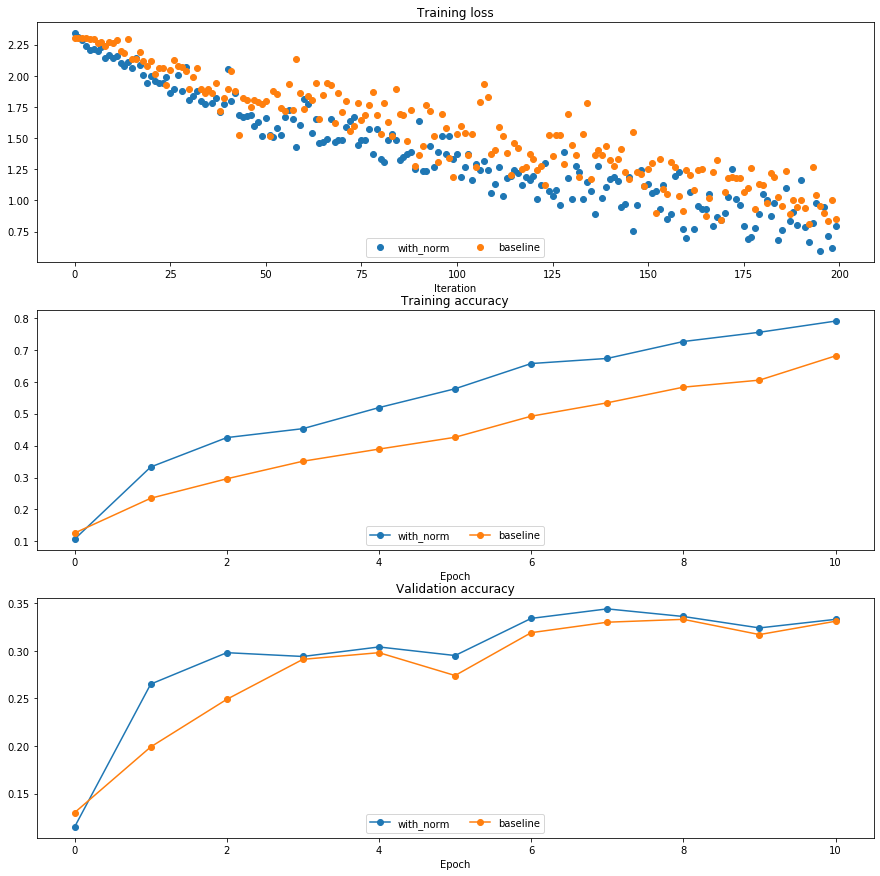

In [65]:
def plot_training_history(title, label, baseline, bn_solvers, plot_fn, bl_marker='.', bn_marker='.', labels=None):
    """utility function for plotting training history"""
    plt.title(title)
    plt.xlabel(label)
    bn_plots = [plot_fn(bn_solver) for bn_solver in bn_solvers]
    bl_plot = plot_fn(baseline)
    num_bn = len(bn_plots)
    for i in range(num_bn):
        label='with_norm'
        if labels is not None:
            label += str(labels[i])
        plt.plot(bn_plots[i], bn_marker, label=label)
    label='baseline'
    if labels is not None:
        label += str(labels[0])
    plt.plot(bl_plot, bl_marker, label=label)
    plt.legend(loc='lower center', ncol=num_bn+1) 

    
plt.subplot(3, 1, 1)
plot_training_history('Training loss','Iteration', solver, [bn_solver], \
                      lambda x: x.loss_history, bl_marker='o', bn_marker='o')
plt.subplot(3, 1, 2)
plot_training_history('Training accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.train_acc_history, bl_marker='-o', bn_marker='-o')
plt.subplot(3, 1, 3)
plot_training_history('Validation accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.val_acc_history, bl_marker='-o', bn_marker='-o')

plt.gcf().set_size_inches(15, 15)
plt.show()

# Batch normalization and initialization
We will now run a small experiment to study the interaction of batch normalization and weight initialization.

The first cell will train 8-layer networks both with and without batch normalization using different scales for weight initialization. The second layer will plot training accuracy, validation set accuracy, and training loss as a function of the weight initialization scale.

In [66]:
np.random.seed(231)
# Try training a very deep net with batchnorm
hidden_dims = [50, 50, 50, 50, 50, 50, 50]
num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

bn_solvers_ws = {}
solvers_ws = {}
weight_scales = np.logspace(-4, 0, num=20)
for i, weight_scale in enumerate(weight_scales):
  print('Running weight scale %d / %d' % (i + 1, len(weight_scales)))
  bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization='batchnorm')
  model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)

  bn_solver = Solver(bn_model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
  bn_solver.train()
  bn_solvers_ws[weight_scale] = bn_solver

  solver = Solver(model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
  solver.train()
  solvers_ws[weight_scale] = solver

Running weight scale 1 / 20
Running weight scale 2 / 20
Running weight scale 3 / 20
Running weight scale 4 / 20
Running weight scale 5 / 20
Running weight scale 6 / 20
Running weight scale 7 / 20
Running weight scale 8 / 20
Running weight scale 9 / 20
Running weight scale 10 / 20
Running weight scale 11 / 20
Running weight scale 12 / 20
Running weight scale 13 / 20
Running weight scale 14 / 20
Running weight scale 15 / 20
Running weight scale 16 / 20
Running weight scale 17 / 20
Running weight scale 18 / 20
Running weight scale 19 / 20
Running weight scale 20 / 20


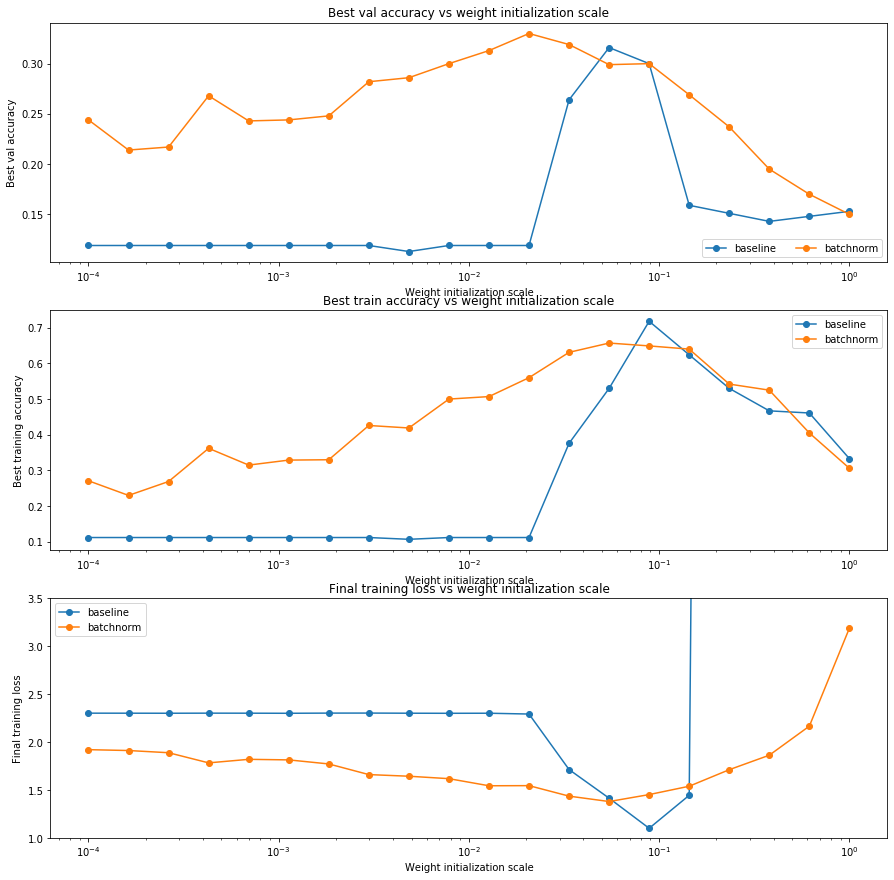

In [67]:
# Plot results of weight scale experiment
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
  best_train_accs.append(max(solvers_ws[ws].train_acc_history))
  bn_best_train_accs.append(max(bn_solvers_ws[ws].train_acc_history))
  
  best_val_accs.append(max(solvers_ws[ws].val_acc_history))
  bn_best_val_accs.append(max(bn_solvers_ws[ws].val_acc_history))
  
  final_train_loss.append(np.mean(solvers_ws[ws].loss_history[-100:]))
  bn_final_train_loss.append(np.mean(bn_solvers_ws[ws].loss_history[-100:]))
  
plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()
plt.gca().set_ylim(1.0, 3.5)

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 1:
Describe the results of this experiment. How does the scale of weight initialization affect models with/without batch normalization differently, and why?

## Answer:
[FILL THIS IN]


# Batch normalization and batch size
We will now run a small experiment to study the interaction of batch normalization and batch size.

The first cell will train 6-layer networks both with and without batch normalization using different batch sizes. The second layer will plot training accuracy and validation set accuracy over time.

In [68]:
def run_batchsize_experiments(normalization_mode):
    np.random.seed(231)
    # Try training a very deep net with batchnorm
    hidden_dims = [100, 100, 100, 100, 100]
    num_train = 1000
    small_data = {
      'X_train': data['X_train'][:num_train],
      'y_train': data['y_train'][:num_train],
      'X_val': data['X_val'],
      'y_val': data['y_val'],
    }
    n_epochs=10
    weight_scale = 2e-2
    batch_sizes = [5,10,50]
    lr = 10**(-3.5)
    solver_bsize = batch_sizes[0]

    print('No normalization: batch size = ',solver_bsize)
    model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)
    solver = Solver(model, small_data,
                    num_epochs=n_epochs, batch_size=solver_bsize,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
                    },
                    verbose=False)
    solver.train()
    
    bn_solvers = []
    for i in range(len(batch_sizes)):
        b_size=batch_sizes[i]
        print('Normalization: batch size = ',b_size)
        bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=normalization_mode)
        bn_solver = Solver(bn_model, small_data,
                        num_epochs=n_epochs, batch_size=b_size,
                        update_rule='adam',
                        optim_config={
                          'learning_rate': lr,
                        },
                        verbose=False)
        bn_solver.train()
        bn_solvers.append(bn_solver)
        
    return bn_solvers, solver, batch_sizes

batch_sizes = [5,10,50]
bn_solvers_bsize, solver_bsize, batch_sizes = run_batchsize_experiments('batchnorm')

No normalization: batch size =  5
Normalization: batch size =  5
Normalization: batch size =  10
Normalization: batch size =  50


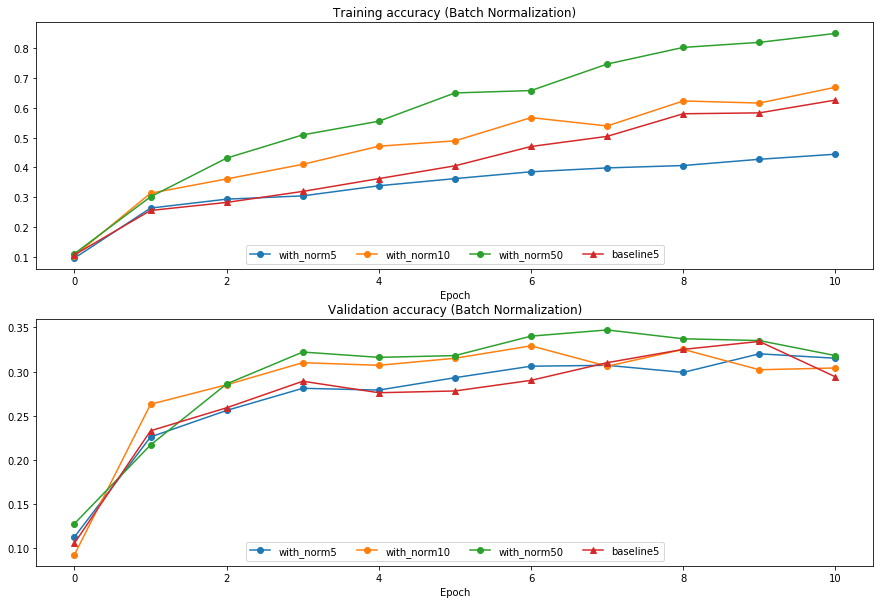

In [69]:
plt.subplot(2, 1, 1)
plot_training_history('Training accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)
plt.subplot(2, 1, 2)
plot_training_history('Validation accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)

plt.gcf().set_size_inches(15, 10)
plt.show()

## Inline Question 2:
Describe the results of this experiment. What does this imply about the relationship between batch normalization and batch size? Why is this relationship observed?

## Answer:
[FILL THIS IN]


# Layer Normalization
Batch normalization has proved to be effective in making networks easier to train, but the dependency on batch size makes it less useful in complex networks which have a cap on the input batch size due to hardware limitations. 

Several alternatives to batch normalization have been proposed to mitigate this problem; one such technique is Layer Normalization [2]. Instead of normalizing over the batch, we normalize over the features. In other words, when using Layer Normalization, each feature vector corresponding to a single datapoint is normalized based on the sum of all terms within that feature vector.

[2] [Ba, Jimmy Lei, Jamie Ryan Kiros, and Geoffrey E. Hinton. "Layer Normalization." stat 1050 (2016): 21.](https://arxiv.org/pdf/1607.06450.pdf)

## Inline Question 3:
Which of these data preprocessing steps is analogous to batch normalization, and which is analogous to layer normalization?

1. Scaling each image in the dataset, so that the RGB channels for each row of pixels within an image sums up to 1.
2. Scaling each image in the dataset, so that the RGB channels for all pixels within an image sums up to 1.  
3. Subtracting the mean image of the dataset from each image in the dataset.
4. Setting all RGB values to either 0 or 1 depending on a given threshold.

## Answer:
[FILL THIS IN]


# Layer Normalization: Implementation

Now you'll implement layer normalization. This step should be relatively straightforward, as conceptually the implementation is almost identical to that of batch normalization. One significant difference though is that for layer normalization, we do not keep track of the moving moments, and the testing phase is identical to the training phase, where the mean and variance are directly calculated per datapoint.

Here's what you need to do:

* In `cs231n/layers.py`, implement the forward pass for layer normalization in the function `layernorm_backward`. 

Run the cell below to check your results.
* In `cs231n/layers.py`, implement the backward pass for layer normalization in the function `layernorm_backward`. 

Run the second cell below to check your results.
* Modify `cs231n/classifiers/fc_net.py` to add layer normalization to the `FullyConnectedNet`. When the `normalization` flag is set to `"layernorm"` in the constructor, you should insert a layer normalization layer before each ReLU nonlinearity. 

Run the third cell below to run the batch size experiment on layer normalization.

In [72]:
# Check the training-time forward pass by checking means and variances
# of features both before and after layer normalization   

# Simulate the forward pass for a two-layer network
np.random.seed(231)
N, D1, D2, D3 =4, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before layer normalization:')
print_mean_std(a,axis=1)

gamma = np.ones(D3)
beta = np.zeros(D3)
# Means should be close to zero and stds close to one
print('After layer normalization (gamma=1, beta=0)')
a_norm, _ = layernorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=1)

gamma = np.asarray([3.0,3.0,3.0])
beta = np.asarray([5.0,5.0,5.0])
# Now means should be close to beta and stds close to gamma
print('After layer normalization (gamma=', gamma, ', beta=', beta, ')')
a_norm, _ = layernorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=1)

Before layer normalization:
  means:  [-59.06673243 -47.60782686 -43.31137368 -26.40991744]
  stds:   [10.07429373 28.39478981 35.28360729  4.01831507]

After layer normalization (gamma=1, beta=0)
  means:  [-4.81096644e-16  0.00000000e+00  7.40148683e-17 -5.92118946e-16]
  stds:   [0.99999995 0.99999999 1.         0.99999969]

After layer normalization (gamma= [3. 3. 3.] , beta= [5. 5. 5.] )
  means:  [5. 5. 5. 5.]
  stds:   [2.99999985 2.99999998 2.99999999 2.99999907]



In [80]:
# Gradient check batchnorm backward pass
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

ln_param = {}
fx = lambda x: layernorm_forward(x, gamma, beta, ln_param)[0]
fg = lambda a: layernorm_forward(x, a, beta, ln_param)[0]
fb = lambda b: layernorm_forward(x, gamma, b, ln_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = layernorm_forward(x, gamma, beta, ln_param)
dx, dgamma, dbeta = layernorm_backward(dout, cache)

#You should expect to see relative errors between 1e-12 and 1e-8
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.433615657860454e-09
dgamma error:  4.519489546032799e-12
dbeta error:  2.5842537629899423e-12


# Layer Normalization and batch size

We will now run the previous batch size experiment with layer normalization instead of batch normalization. Compared to the previous experiment, you should see a markedly smaller influence of batch size on the training history!

No normalization: batch size =  5
Normalization: batch size =  5
Normalization: batch size =  10
Normalization: batch size =  50


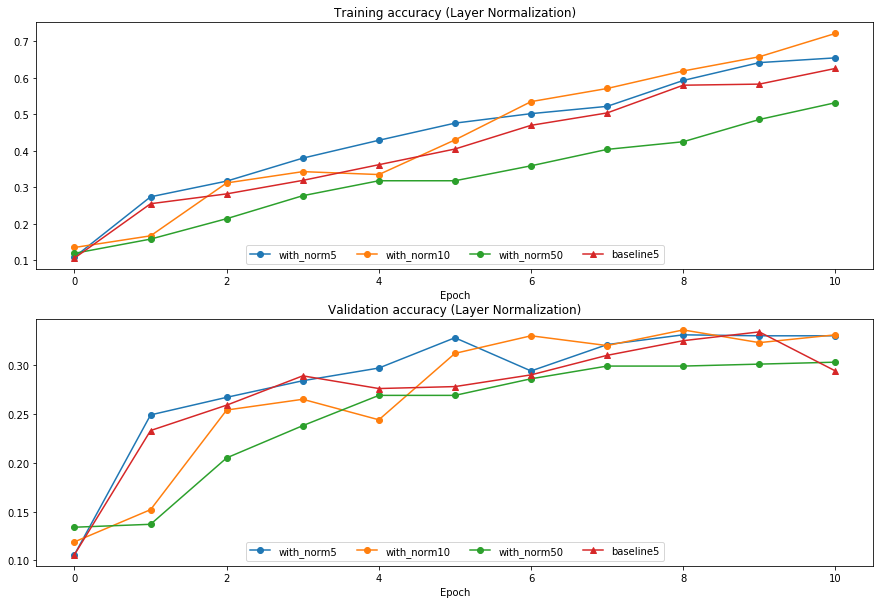

In [81]:
ln_solvers_bsize, solver_bsize, batch_sizes = run_batchsize_experiments('layernorm')

plt.subplot(2, 1, 1)
plot_training_history('Training accuracy (Layer Normalization)','Epoch', solver_bsize, ln_solvers_bsize, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)
plt.subplot(2, 1, 2)
plot_training_history('Validation accuracy (Layer Normalization)','Epoch', solver_bsize, ln_solvers_bsize, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)

plt.gcf().set_size_inches(15, 10)
plt.show()

## Inline Question 4:
When is layer normalization likely to not work well, and why?

1. Using it in a very deep network
2. Having a very small dimension of features
3. Having a high regularization term


## Answer:
[FILL THIS IN]
